In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
X_train_resampled = pd.read_csv('X_train_smoteenn.csv')
y_train_resampled = pd.read_csv('y_train_smoteenn.csv')
# double check if the data is correct
X_train_resampled.head(5)

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,logIncome,sourcing_channel_A,sourcing_channel_B,sourcing_channel_C,sourcing_channel_D,sourcing_channel_E,residence_area_type_Rural,residence_area_type_Urban
0,0.917,17531.0,84140.0,2.0,3.0,1.0,98.690000,7.0,3300.0,4.925003,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.863,18992.0,92450.0,3.0,1.0,2.0,98.770000,11.0,3300.0,4.965907,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.971,9870.0,31570.0,1.0,1.0,0.0,99.170000,8.0,5700.0,4.499275,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.000,16065.0,329550.0,0.0,0.0,0.0,99.770000,2.0,18000.0,5.517921,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.327,21550.0,55360.0,1.0,0.0,0.0,99.055908,22.0,5400.0,4.743196,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
scaler.fit(X_train_resampled.as_matrix())
X_scaled = scaler.transform(X_train_resampled)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import EarlyStopping

/Users/jessie/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def create_baseline(n_features):
    # create model
    model = Sequential()
    model.add(Dense(2*n_features, input_dim=n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features//2, input_dim=2*n_features, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(n_features, input_dim=n_features//2, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def fit_and_roc(name,x_train, y_train, x_valid, y_valid):
    # fit model using SVM, ANN or Random Forest
    # input name: string, specify the name of machine learning model to be applied
    #       x_train, y_train, x_valid, y_valid: dataframe for training and validation
    # output(the function will automaticlly plot AUC curve) model: a model object with "predict" function
    if name == "ann":
        n_features = x_train.shape[1]
        model = create_baseline(n_features)
        callback = EarlyStopping("val_loss", patience=1, verbose=0, mode='auto')
        model.fit(
                X_train, y_train,
                nb_epoch=20, batch_size=25,
                validation_data=(X_valid, y_valid),
                callbacks=[callback], verbose = 1)
    elif name == 'svm':
        model = svm.SVC(probability=True)
        model.fit(x_train, y_train)
    elif name == 'rf':
        model = RandomForestRegressor(n_jobs=2, n_estimators=150)
        model.fit(x_train, y_train)
        # evaluate training error
    y_train_pred = model.predict(x_train)
    y_train_prob = model.predict_proba(x_train)[:, 0]

    fpr, tpr, thresholds = roc_curve(y_train, y_train_prob, pos_label=1)
    if name == 'svm':
        fpr = 1-fpr
        tpr = 1-tpr
    roc_auc = auc(fpr, tpr)
    
    # evaluate testing error
    y_test_pred = model.predict(x_valid)
    y_test_prob = model.predict_proba(x_valid)[:, 0]
    
    fpr_test, tpr_test, threshold_test = roc_curve(y_valid, y_test_prob, pos_label=1)
    if name == 'svm':
        fpr_test = 1-fpr_test
        tpr_test = 1-tpr_test
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # plot roc
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, \
             color='darkorange', lw=2, linestyle='-', label='Training ROC Curve (area = {0:.2f})'.format(roc_auc))
    plt.plot(fpr_test, tpr_test, \
             color='deeppink', lw=2, linestyle='-', label='Testing ROC Curve (area = {0:.2f})'.format(roc_auc_test))
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return model

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y_train_resampled['renewal'].values, random_state=666, train_size=0.80)

/Users/jessie/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


/Users/jessie/anaconda3/lib/python3.5/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 81428 samples, validate on 20358 samples
Epoch 1/20
81428/81428 [==============================] - 11s 139us/step - loss: 0.4634 - acc: 0.7876 - val_loss: 0.4073 - val_acc: 0.8232
Epoch 2/20
81428/81428 [==============================] - 11s 137us/step - loss: 0.4083 - acc: 0.8212 - val_loss: 0.4015 - val_acc: 0.8249
Epoch 3/20
81428/81428 [==============================] - 11s 137us/step - loss: 0.4036 - acc: 0.8228 - val_loss: 0.3971 - val_acc: 0.8267
Epoch 4/20
81428/81428 [==============================] - 11s 138us/step - loss: 0.4019 - acc: 0.8245 - val_loss: 0.3980 - val_acc: 0.8261


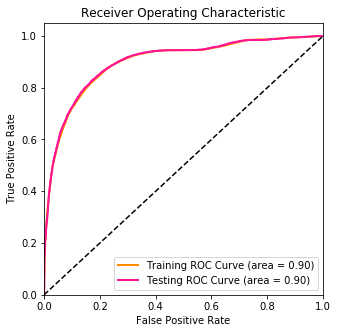

In [8]:
NN_mode  = fit_and_roc('ann',X_train, y_train, X_valid, y_valid)

## Predict renewal probability of test set